In [ ]:
#!conda install -y pytorch torchvision -c pytorch

Moons

In [5]:
import torch
import torch.nn as nn

class MoonsModel(nn.Module):
  def __init__(self, n1=2, n2=3, n3=3):
    super(MoonsModel, self).__init__()
    self.fc1 = nn.Linear(in_features=n1, out_features=n2)
    self.fc_act1 = nn.Sigmoid()
    self.fc2 = nn.Linear(in_features=n2, out_features=n3)
    self.fc_act2 = nn.Sigmoid()
    self.fc3 = nn.Linear(in_features=n3, out_features=1)
    self.fc_act3 = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc_act1(x)
    x = self.fc2(x)
    x = self.fc_act2(x)
    x = self.fc3(x)
    x = self.fc_act3(x)
    x = x.view(-1)
    return x

In [14]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


def get_dataset(N_SAMPLES, BATCH_SIZE):
  X, y = make_moons(n_samples=N_SAMPLES, noise=0.2)
  dataset = TensorDataset(torch.FloatTensor(X), torch.FloatTensor(y))
  data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
  plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
  return data_loader

def get_device():
  if torch.cuda.is_available():DEVICE = 'cuda'
  elif torch.backends.mps.is_available(): DEVICE = 'mps'
  else: DEVICE = 'cpu'
  return DEVICE

def train(data_loader, N_SAMPLES, model, loss_function, optimizer, DEVICE):
  epoch_loss, n_corrects = 0., 0
  for X, y in data_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    pred = model.forward(X)
    loss = loss_function(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * len(X)
    pred = (pred > 0.5).type(torch.float)
    n_corrects += (pred == y).sum().item()

  epoch_loss /= N_SAMPLES
  epoch_acc = n_corrects / N_SAMPLES
  return epoch_loss, epoch_acc

def vis_losses_accs(losses, accs):
  fig, axes = plt.subplots(2,1, figsize=(7,7))
  axes[0].plot(losses)
  axes[0].set_ylabel('BCELoss')

  axes[1].plot(accs)
  axes[1].set_ylabel('Accuracy')
  axes[1].set_xlabel('Epoch')

Neural : [2, 3, 5], Loss : 0.30892564821243285, Accuracy: 0.87


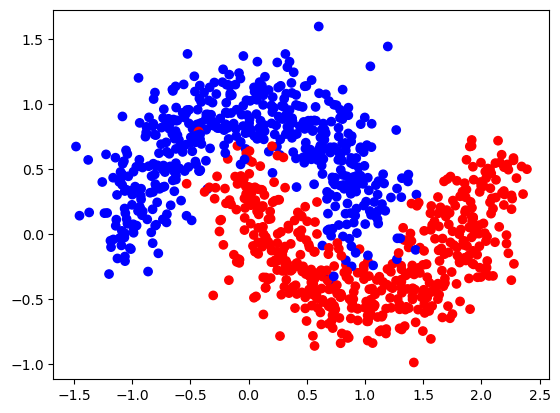

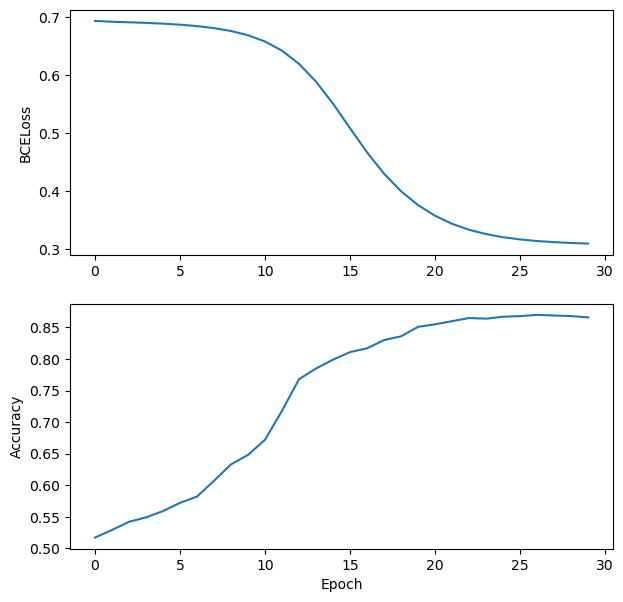

In [40]:
import torch
import torch.nn as nn
from torch.optim import SGD

N_SAMPLES = 1000
BATCH_SIZE = 16
EPOCHS = 30
LR = 0.13
DEVICE = get_device()
layer_neural = [2, 3, 5]
data_loader = get_dataset(N_SAMPLES, BATCH_SIZE)

model = MoonsModel(*layer_neural).to(DEVICE)
loss_function = nn.BCELoss()
optimizer = SGD(model.parameters(), lr=LR)

losses, accs = [], []
for epoch in range(EPOCHS):
  epoch_loss, n_corrects = 0., 0
  epoch_loss, epoch_acc = train(data_loader, N_SAMPLES, model, 
                                loss_function, optimizer, DEVICE)

  losses.append(epoch_loss)
  accs.append(epoch_acc)

vis_losses_accs(losses, accs)
print(f'Neural : {layer_neural}, Loss : {min(losses)}, Accuracy: {max(accs)}')

XOR

In [41]:
import torch.nn as nn

class XorModel(nn.Module):
  def __init__(self, n1=3):
    super(XorModel, self).__init__()
    self.fc1 = nn.Linear(in_features=2, out_features=n1)
    self.fc_act1 = nn.Sigmoid()
    self.fc2 = nn.Linear(in_features=n1, out_features=1)
    self.fc_act2 = nn.Sigmoid()


  def forward(self, x):
    x = self.fc1(x)
    x = self.fc_act1(x)
    x = self.fc2(x)
    x = self.fc_act2(x)

    x = x.view(-1)
    return x

In [44]:
from sklearn.datasets import make_blobs
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


def get_dataset(N_SAMPLES, BATCH_SIZE, centers):
  X_, y_ = make_blobs(n_samples=N_SAMPLES, centers=centers, n_features=2, cluster_std=1, random_state=0)
  y_ = y_ // 2
  dataset = TensorDataset(torch.FloatTensor(X_), torch.FloatTensor(y_))
  data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
  return data_loader, X_, y_

def get_device():
  if torch.cuda.is_available():DEVICE = 'cuda'
  # elif torch.backends.mps.is_available(): DEVICE = 'mps'
  else: DEVICE = 'cpu'
  return DEVICE

def train(data_loader, N_SAMPLES, model, loss_function, optimizer, DEVICE):
  epoch_loss, n_corrects = 0., 0
  for X, y in data_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    pred = model.forward(X)
    loss = loss_function(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * len(X)
    pred = (pred > 0.5).type(torch.float)
    n_corrects += (pred == y).sum().item()
  epoch_loss /= N_SAMPLES
  epoch_acc = n_corrects / N_SAMPLES

  return epoch_loss, epoch_acc

def vis_losses_accs(losses, accs, mesh_sample, X_, y_):
  fig, axes = plt.subplots(3, 1, figsize=(7, 21))
  axes[0].scatter(X_[:,0], X_[:,1], c=y_, cmap='bwr')
  axes[1].plot(losses)
  axes[1].set_ylabel('BCELoss')
  axes[2].plot(accs)
  axes[2].set_ylabel('Accuracy')
  axes[2].set_xlabel('Epoch')

  xmin, xmax = axes[0].get_xlim()
  ymin, ymax = axes[0].get_ylim()
  xmesh, ymesh = torch.meshgrid([torch.linspace(xmin, xmax, steps=mesh_sample), torch.linspace(ymin, ymax, steps=mesh_sample)])
  meshset = torch.cat((xmesh.reshape(-1, 1), ymesh.reshape(-1, 1)), 1)


  mesh_pred = model.forward(torch.FloatTensor(meshset).to(get_device()))
  axes[0].scatter(meshset[:,0], meshset[:,1], c=(mesh_pred > 0.5).type(torch.int), cmap='bwr', alpha=0.1)

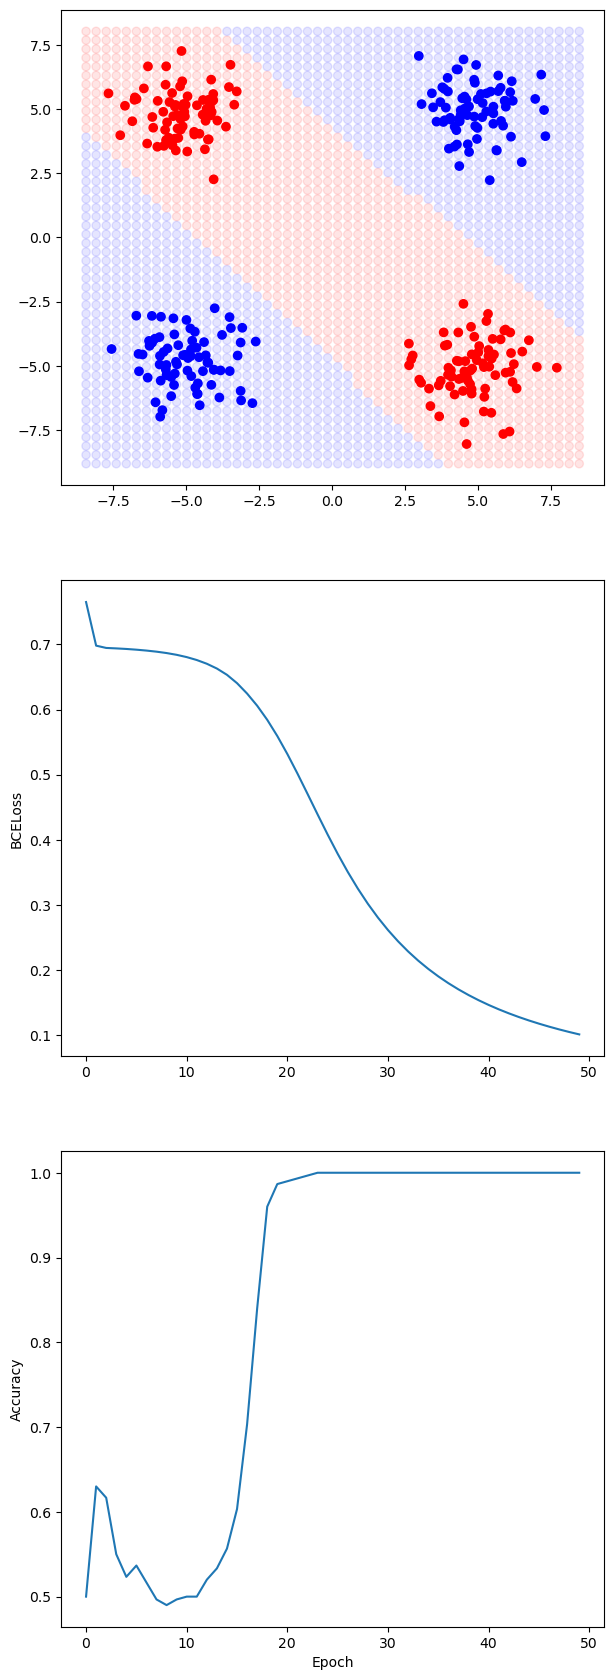

In [45]:
from torch.optim import SGD

N_SAMPLES = 300
BATCH_SIZE = 16
EPOCHS = 50
LR = 0.2
centers = [[-5, -5], [5, 5], [-5, 5], [5, -5]]
mesh_sample = 50

data_loader, X_, y_ = get_dataset(N_SAMPLES, BATCH_SIZE, centers)
DEVICE = get_device()


model = XorModel(2).to(DEVICE)
loss_function = nn.BCELoss()
optimizer = SGD(model.parameters(), lr=LR)

losses, accs = [], []
for epoch in range(EPOCHS):
  epoch_loss, epoch_acc = train(data_loader, N_SAMPLES, model, loss_function, optimizer, DEVICE)
  losses.append(epoch_loss)
  accs.append(epoch_acc)

vis_losses_accs(losses, accs, mesh_sample, X_, y_)

